# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


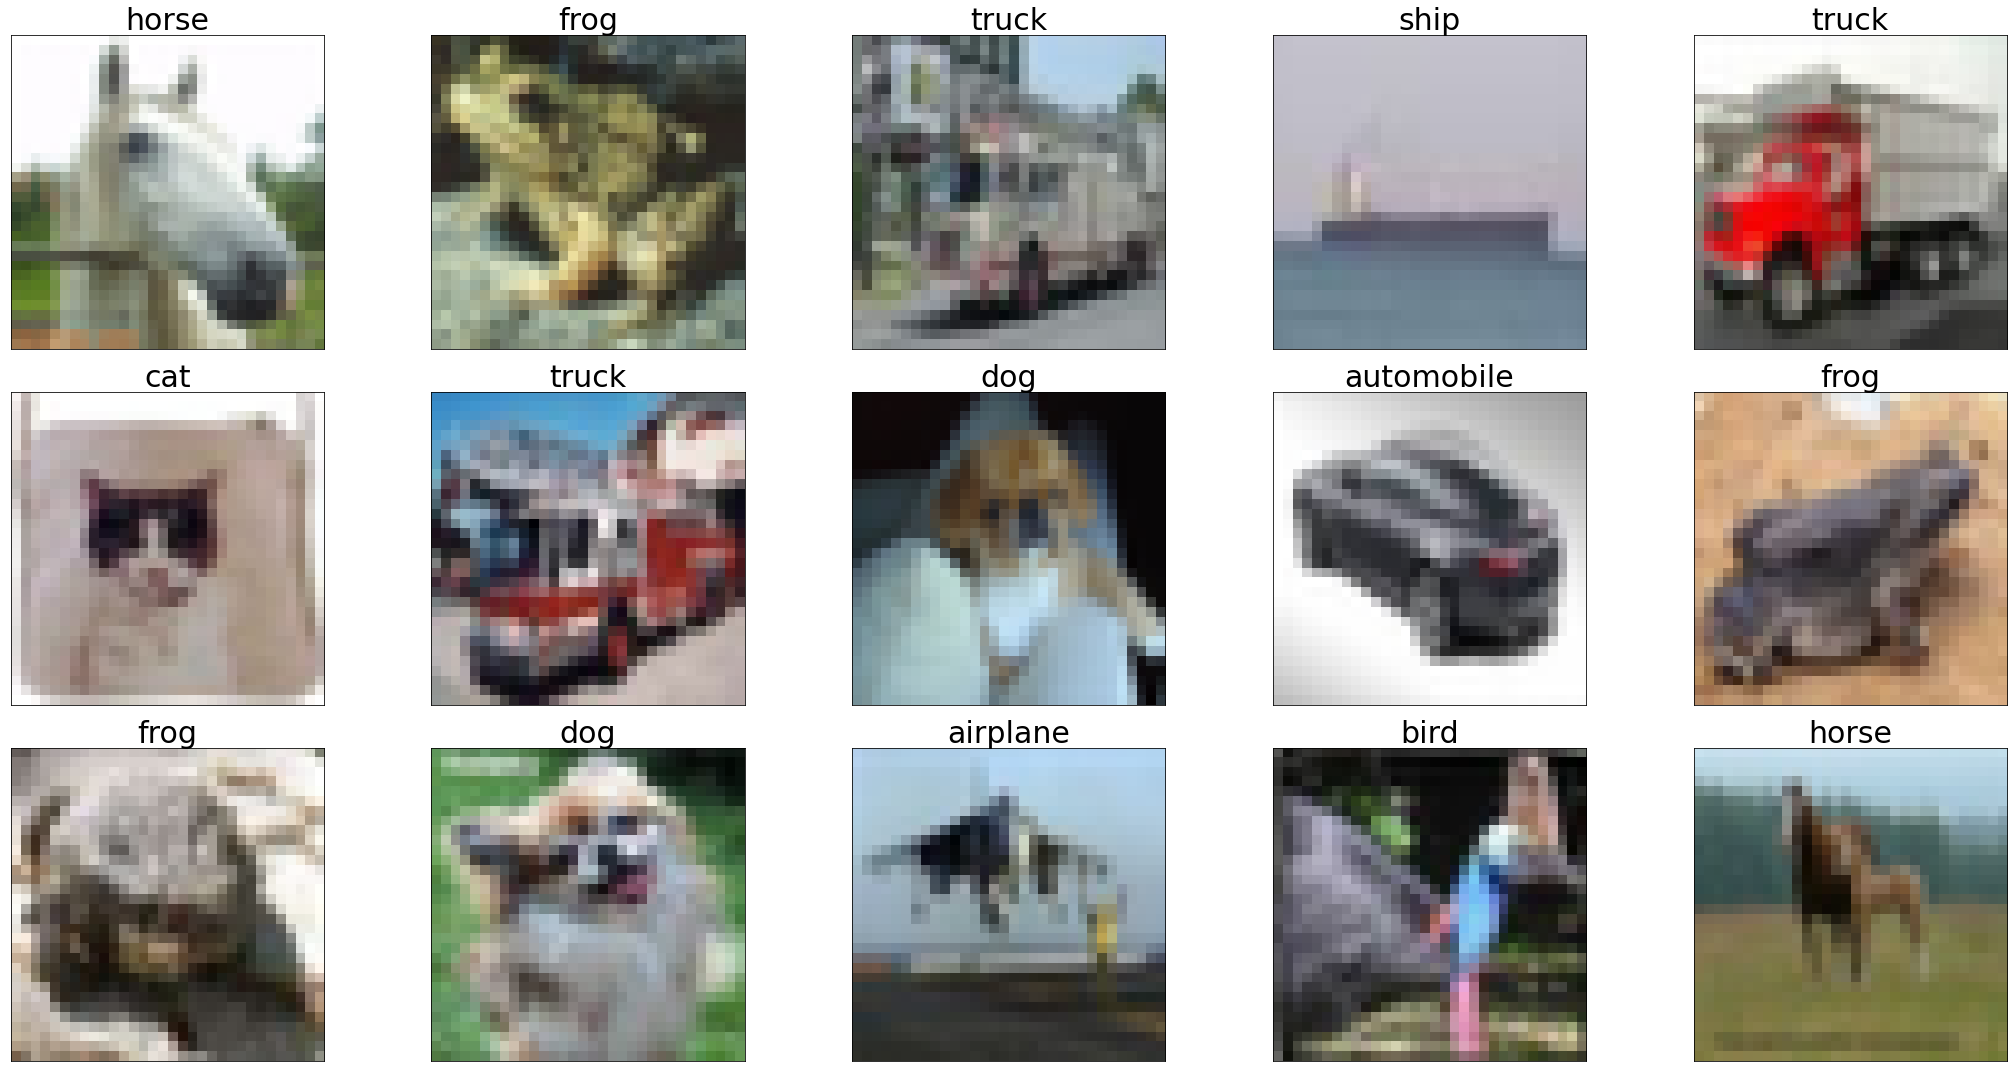

In [94]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [95]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

my_transform = Compose(
    [ToTensor(),
     Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

my_batch_size = 100


train_dataset = CIFAR10(root='./data', 
                        train=True,
                        download=True,
                        transform=my_transform)

train_loader = DataLoader(train_dataset, batch_size=my_batch_size, shuffle=True, num_workers=2)

test_dataset = CIFAR10(root='./data', 
                       train=False,
                       download=True,
                       transform=my_transform)

test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## Convolutional neural network with batch norm, 3 layers of feature extraction with three layers of dense neural network. TO acquire specific accuracy - I acquired 77% on test set, approx 5 epochs of learning rate = 0.1 + 3 epochs of learning rate = 0.03. I tested models with smaller number of convolutional layers, but the accuracy was not exceeding 70%, and dropouts make it worse, so I decided to make feature extraction deeper. It contains LR scheduler, in a form of multisteplr.


In [96]:

class CNN(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 32, 3)
      self.conv2 = nn.Conv2d(32, 64, 3)
      self.conv3 = nn.Conv2d(64,128,3)
      self.pool = nn.MaxPool2d(2, 2)
      self.fc1 = nn.Linear(128*2*2, 200)
      self.fc2 = nn.Linear(200, 50)
      self.fc3 = nn.Linear(50, 10)
      self.batch2d_32 = nn.BatchNorm2d(32)
      self.batch2d_64 = nn.BatchNorm2d(64)
      self.batch2d_128 = nn.BatchNorm2d(128)
      self.batch1d_200 = nn.BatchNorm1d(200)
      self.dropout = nn.Dropout(0.3)

    def forward(self,x):
      x = self.pool(F.relu(self.conv1(x)))
      #x = self.dropout(x)
      #print(x.shape)
      x = self.batch2d_32(x)
      #print(x.shape)
      x = self.pool(F.relu(self.conv2(x)))
      #x = self.dropout(x)
      #print(x.shape)
      x = self.batch2d_64(x)
      #print(x.shape)
      x = self.pool(F.relu(self.conv3(x)))
      #x = self.dropout(x)
      #print(x.shape)
      x = self.batch2d_128(x)
      #print(x.shape)
      x = torch.flatten(x, 1)
      #print(x.shape)
      x = F.relu(self.fc1(x))
      x = self.batch1d_200(x)
      #x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x
    
      
cnn = CNN()


[1,   100] loss: 1.733
[1,   200] loss: 1.462
[1,   300] loss: 1.265
[1,   400] loss: 1.228
[1,   500] loss: 1.139
[2,   100] loss: 1.019
[2,   200] loss: 1.011
[2,   300] loss: 0.971
[2,   400] loss: 0.942
[2,   500] loss: 0.910
[3,   100] loss: 0.808
[3,   200] loss: 0.797
[3,   300] loss: 0.791
[3,   400] loss: 0.780
[3,   500] loss: 0.771
[4,   100] loss: 0.674
[4,   200] loss: 0.669
[4,   300] loss: 0.691
[4,   400] loss: 0.685
[4,   500] loss: 0.687
[5,   100] loss: 0.576
[5,   200] loss: 0.585
[5,   300] loss: 0.597
[5,   400] loss: 0.612
[5,   500] loss: 0.602
[6,   100] loss: 0.435
[6,   200] loss: 0.381
[6,   300] loss: 0.387
[6,   400] loss: 0.381
[6,   500] loss: 0.372
[7,   100] loss: 0.277
[7,   200] loss: 0.313
[7,   300] loss: 0.320
[7,   400] loss: 0.325
[7,   500] loss: 0.328
[8,   100] loss: 0.235
[8,   200] loss: 0.252
[8,   300] loss: 0.259
[8,   400] loss: 0.277
[8,   500] loss: 0.274
[9,   100] loss: 0.178
[9,   200] loss: 0.178
[9,   300] loss: 0.167
[9,   400] 

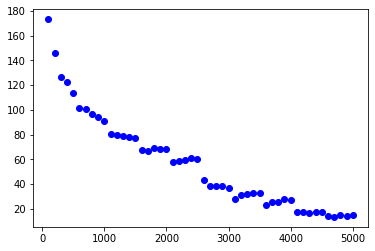

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=0.3)
visual_loss = []
x = []
j = 0
num_of_epochs = 10
correct = 0
total = 0
for epoch in range(num_of_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            x.append(j)
            visual_loss.append(running_loss)
            running_loss = 0.0

        j+=1
    scheduler.step()
print('Finished Training')
print('Accuracy of the network on the train images is greater than: %d %%' % (
    100 * correct / total))
plt.scatter(x, visual_loss, c='blue')
plt.show()

In [98]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f56b4bd1320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f56b4bd1320>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Accuracy of the network on the 10000 test images: 76 %


## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

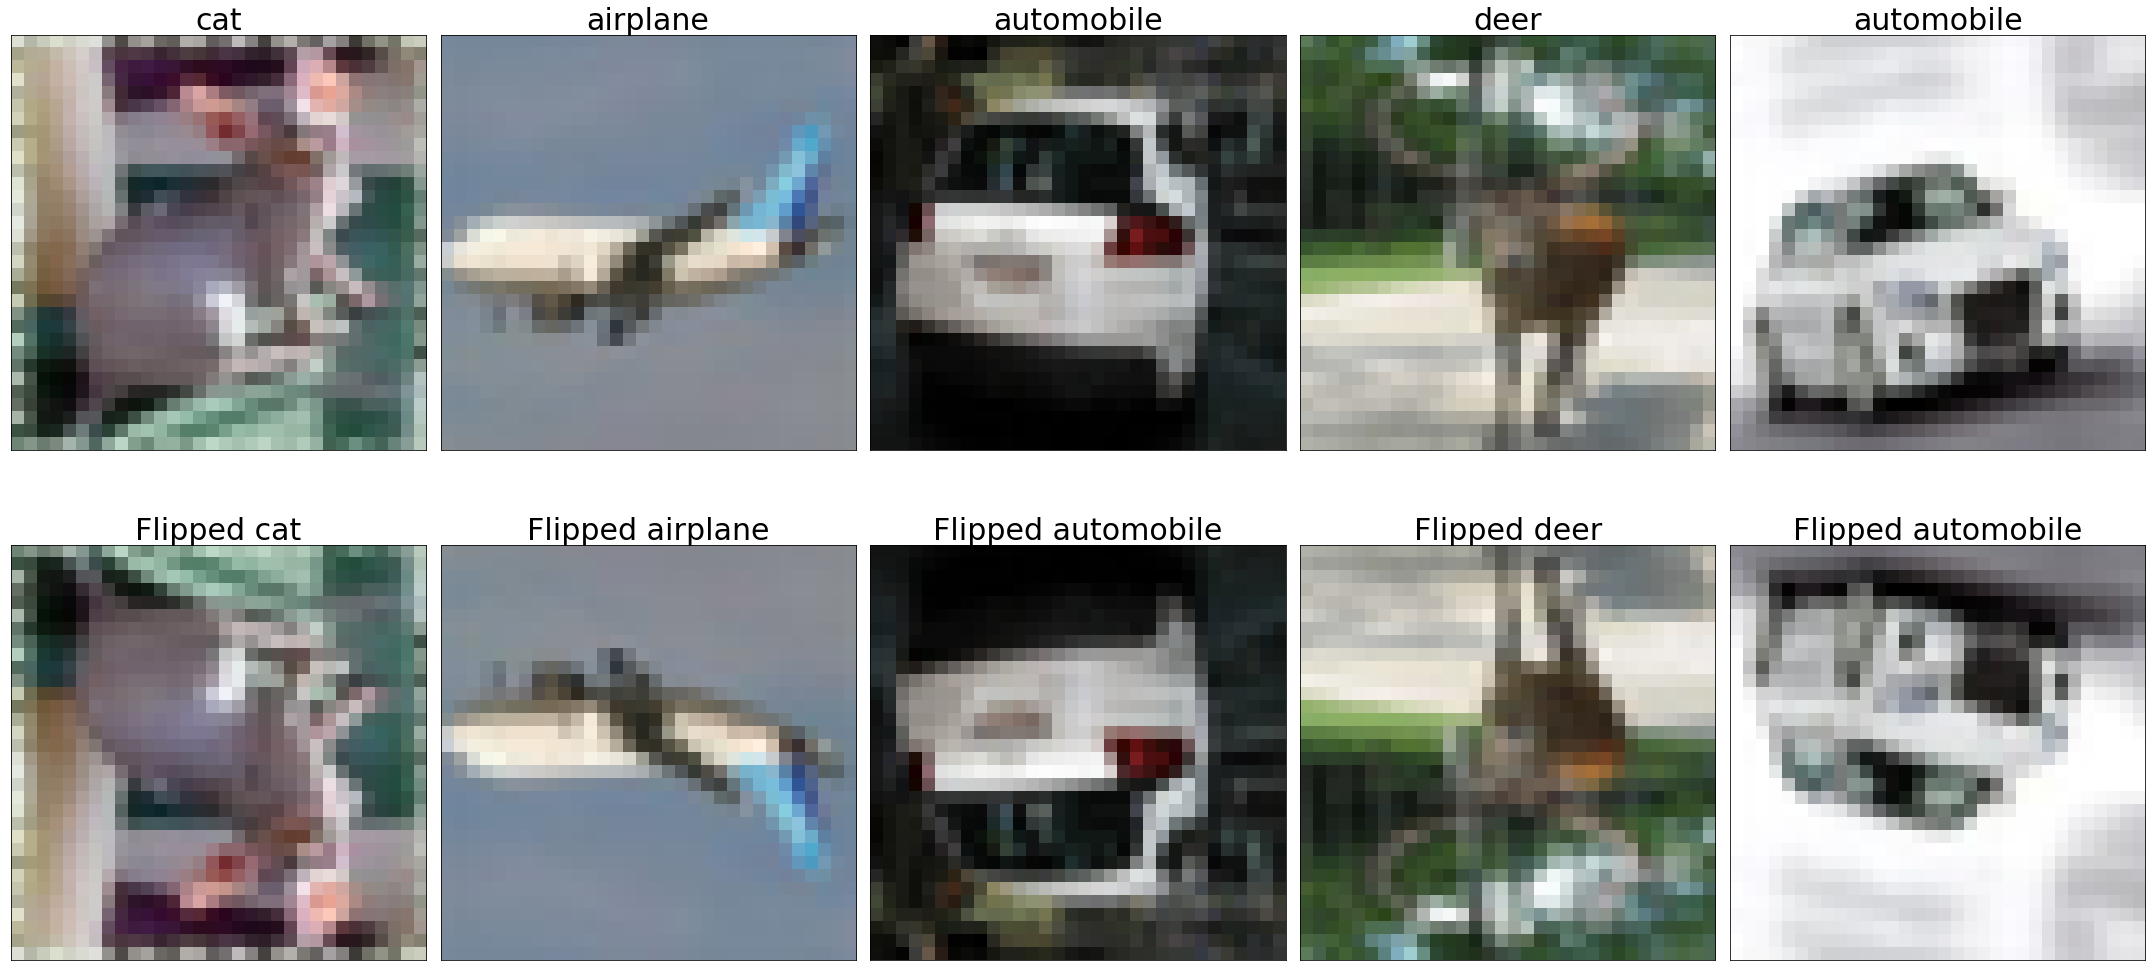

In [82]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

WYBRANĄ TRANSFORMACJĄ TUTAJ BYŁA TRANSFORMACJA AFINICZNA POMIESZANA Z TRANSFORMACJĄ KOLORÓW/JASNOŚCI. OBIE RANDOMOWE. UCZENIE ZAJMOWAŁO DŁUGO.

In [85]:
my_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees = 180, translate = (0.5,0.5),scale = (0.5,2)),torchvision.transforms.ColorJitter(),ToTensor()])
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=my_transform)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=my_transform)


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [89]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,12,14], gamma=0.3)
visual_loss = []
x = []
j = 0
num_of_epochs = 16
for epoch in range(num_of_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            x.append(j)
            visual_loss.append(running_loss)
            running_loss = 0.0

        j+=1
    scheduler.step()
print('Finished Training')
plt.scatter(x, visual_loss, c='blue')
plt.show()

[1,   100] loss: 2.170
[1,   200] loss: 2.124
[1,   300] loss: 2.096
[1,   400] loss: 2.070
[1,   500] loss: 2.041
[2,   100] loss: 2.040
[2,   200] loss: 2.033
[2,   300] loss: 2.003
[2,   400] loss: 2.017
[2,   500] loss: 2.002
[3,   100] loss: 1.989
[3,   200] loss: 1.971
[3,   300] loss: 1.964
[3,   400] loss: 1.954
[3,   500] loss: 1.954
[4,   100] loss: 1.936
[4,   200] loss: 1.910
[4,   300] loss: 1.908
[4,   400] loss: 1.927
[4,   500] loss: 1.907
[5,   100] loss: 1.894
[5,   200] loss: 1.887
[5,   300] loss: 1.877
[5,   400] loss: 1.881
[5,   500] loss: 1.865
[6,   100] loss: 1.859
[6,   200] loss: 1.846
[6,   300] loss: 1.861
[6,   400] loss: 1.859
[6,   500] loss: 1.837
[7,   100] loss: 1.823
[7,   200] loss: 1.822
[7,   300] loss: 1.837
[7,   400] loss: 1.825
[7,   500] loss: 1.828
[8,   100] loss: 1.805
[8,   200] loss: 1.813
[8,   300] loss: 1.820
[8,   400] loss: 1.805
[8,   500] loss: 1.808
[9,   100] loss: 1.762
[9,   200] loss: 1.740
[9,   300] loss: 1.734
[9,   400] 

KeyboardInterrupt: ignored

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [113]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [141]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2021-22/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
images = imgs
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

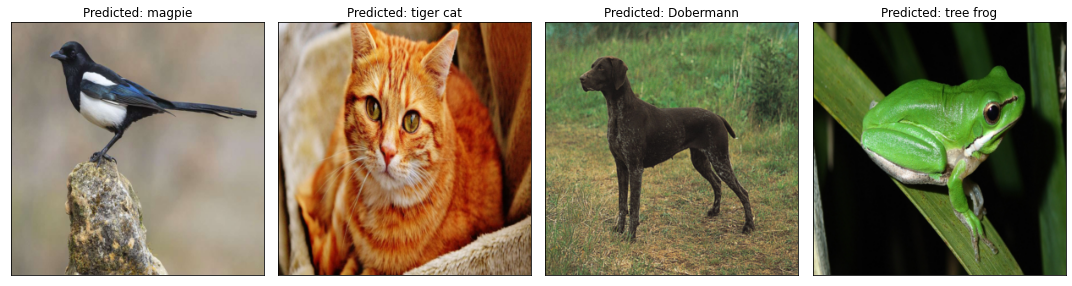

In [115]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [116]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

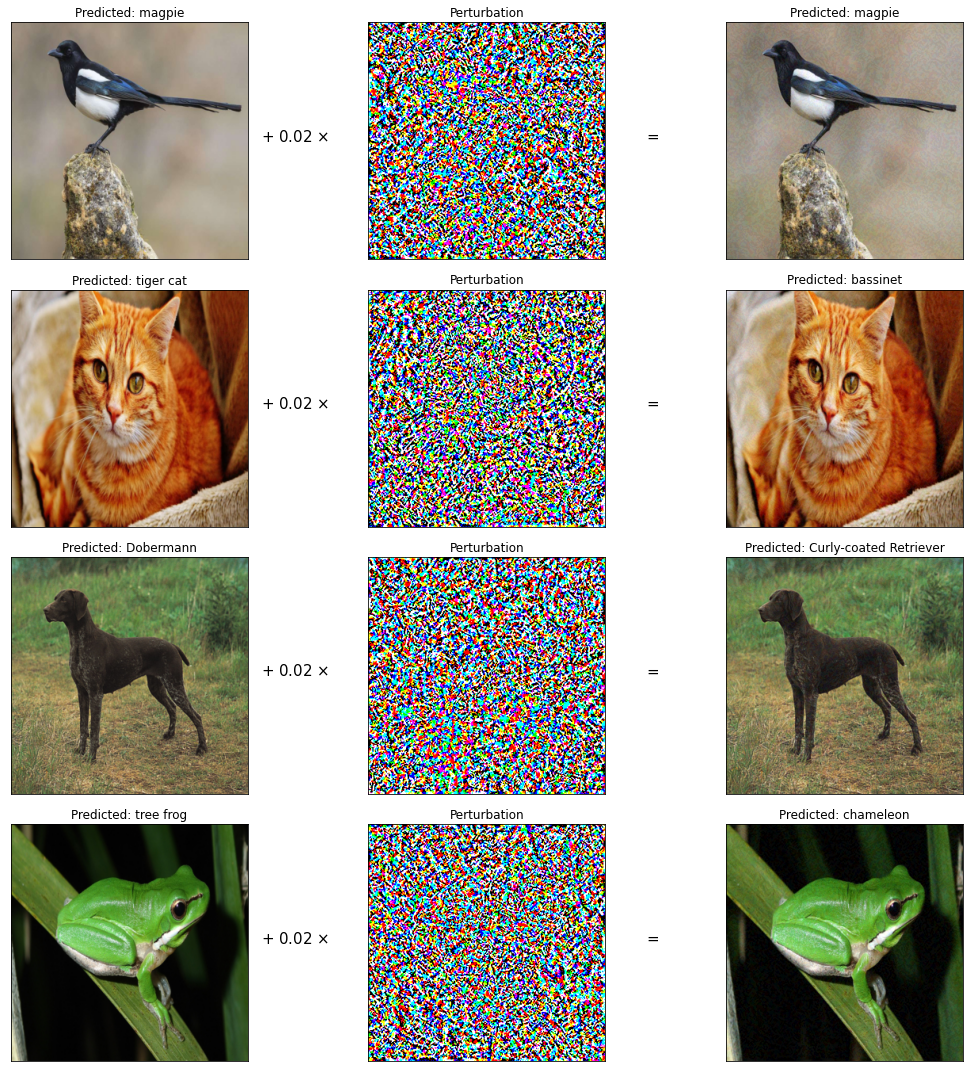

In [117]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji

### SROKA

In [154]:
eps = 0.000
increment   = 0.01
imgs = [images[0]]
imgs = torch.stack(imgs)
i = 0
loss = nn.CrossEntropyLoss()
imgs.requires_grad = True
outputs = model(imgs)
pred = torch.argmax(outputs, 1)
cost = loss(outputs, pred)
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]
while(True):
  # FGSM 
  adv_imgs = imgs + eps * grad.sign()
  # clamp to the image range
  adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
  # save gradients for visualisation
  grads = torch.clamp(grad.sign(), min=0, max=1).detach()
  output = model(adv_imgs)
  adv_pred = torch.argmax(output, 1)
  #print(labels[adv_pred])
  #print(eps)
  if(labels[adv_pred]!="magpie"):
    break
  if(i>1000):
    break
  eps = eps + increment
  i+=1
print('Magpie prediction seems to be broken at eps = %f ' % (eps))

Magpie prediction seems to be broken at eps = 0.190000 


### PRZYKŁADY ADWERSARIALNE DLA MOJEGO MODELU


In [130]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!
test_dataset = CIFAR10(root='.',train=False,download=True,transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
images, labels = iter(test_loader).next()
classes = test_dataset.classes
#print(classes)


Files already downloaded and verified


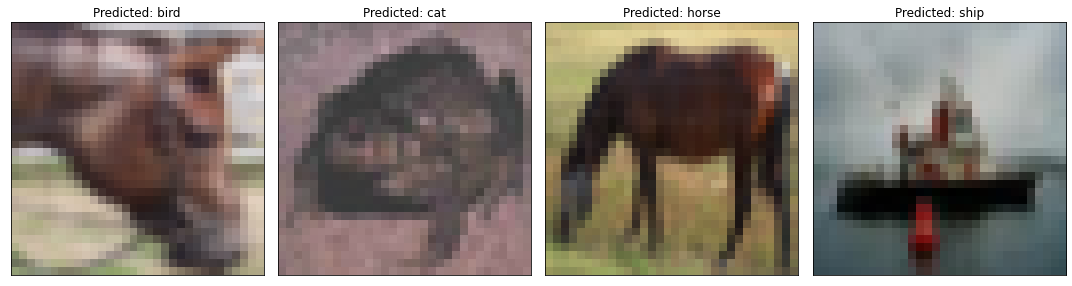

In [131]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych
output = cnn(images)
pred = torch.argmax(output, 1)
# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, images, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {classes[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
images.requires_grad = True

# run the model and calculate the loss
outputs = cnn(images)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, images, create_graph=False)[0]

# FGSM 
adv_imgs = images + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()





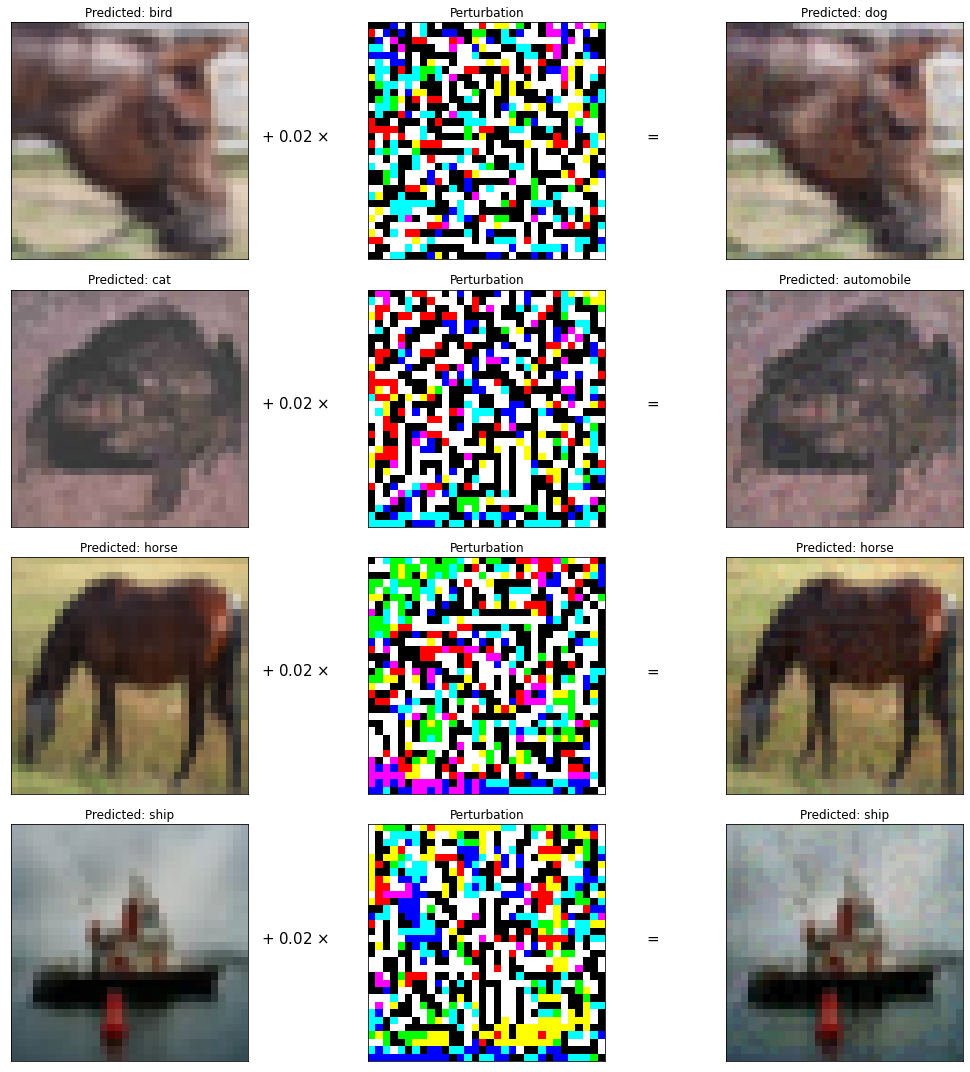

In [132]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu
output = cnn(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, images, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {classes[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {classes[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()